Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [22]:
import pathlib
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau
from glob import glob
import random

# Suppress future warnings
import warnings
warnings.filterwarnings("ignore")

In [23]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [24]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [25]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [26]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [27]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2, subset='training',
    interpolation='bilinear', follow_links=False
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [28]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2, subset='validation',
    interpolation='bilinear', follow_links=False
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [29]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [30]:
### your code goes here, you can use training or validation data to visualize

# Custom Functions for plotting

# Function to generate image map
def generate_image_map(image_ds,batch_num=1):
  # Dictionary to store one image per label (0 to 9)
  label_image_map = {}
  # Iterate through the dataset without limiting the number of batches
  for images, labels in image_ds.skip(batch_num-1).take(1):
      # Loop through each image and its corresponding label
      for image, label in zip(images.numpy(), labels.numpy()):
          # If we haven't already stored an image for this label
          if label not in label_image_map:
              label_image_map[label] = image  # Store the image with the unique label
          # Stop once we have one image for each label (0 to 9)
          if len(label_image_map) == 10:
              break  # Exit the inner loop if all 10 labels are found
      if len(label_image_map) == 10:
          break  # Exit outer loop once all labels are covered
  # Sort the dictionary by keys
  sorted_image_map=dict(sorted(label_image_map.items()))
  # Display the keys of the dictionary to check which labels have been collected
  print("Labels found:", sorted_image_map.keys())
  return sorted_image_map


# Function to plot sample images
def plot_sample_images(class_names, label_image_map):
  plt.figure(figsize=(20, 10))
  for idx, (label, image) in enumerate(label_image_map.items()):
      plt.subplot(2, 5, idx + 1)  # Create a 2x5 grid for the images
      plt.imshow(image.astype("uint8"))  # Display the image
      plt.title(f"Class: {class_names[label]}")  # Display the class name
      plt.axis('off')  # Turn off the axis
  # Show the plot with all images
  plt.tight_layout()
  plt.show()

In [31]:
# Genarate random batch number between 0 and 10
batch_num=random.randint(1,11)
batch_num

8

Labels found: dict_keys([0, 1, 2, 3, 4, 5, 7, 8])


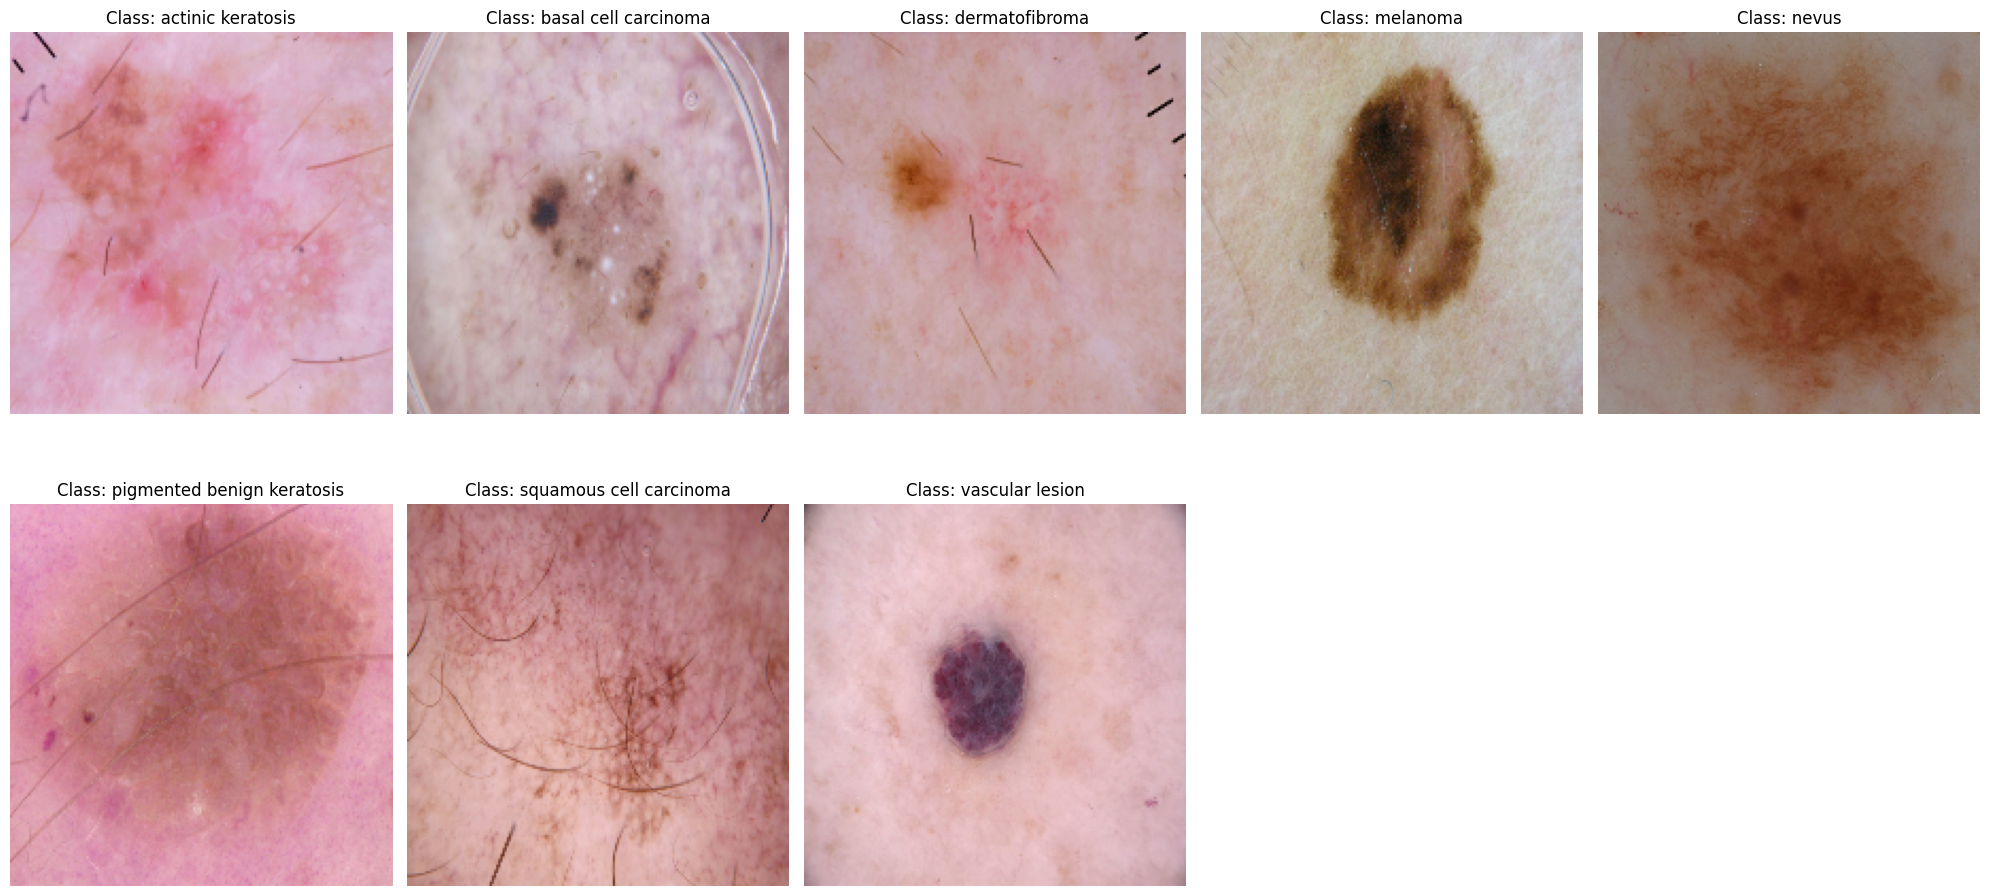

In [32]:
# Visualize Train Data
train_image_map=generate_image_map(train_ds,batch_num)
plot_sample_images(class_names,train_image_map)

Labels found: dict_keys([1, 3, 4, 5, 6, 7, 8])


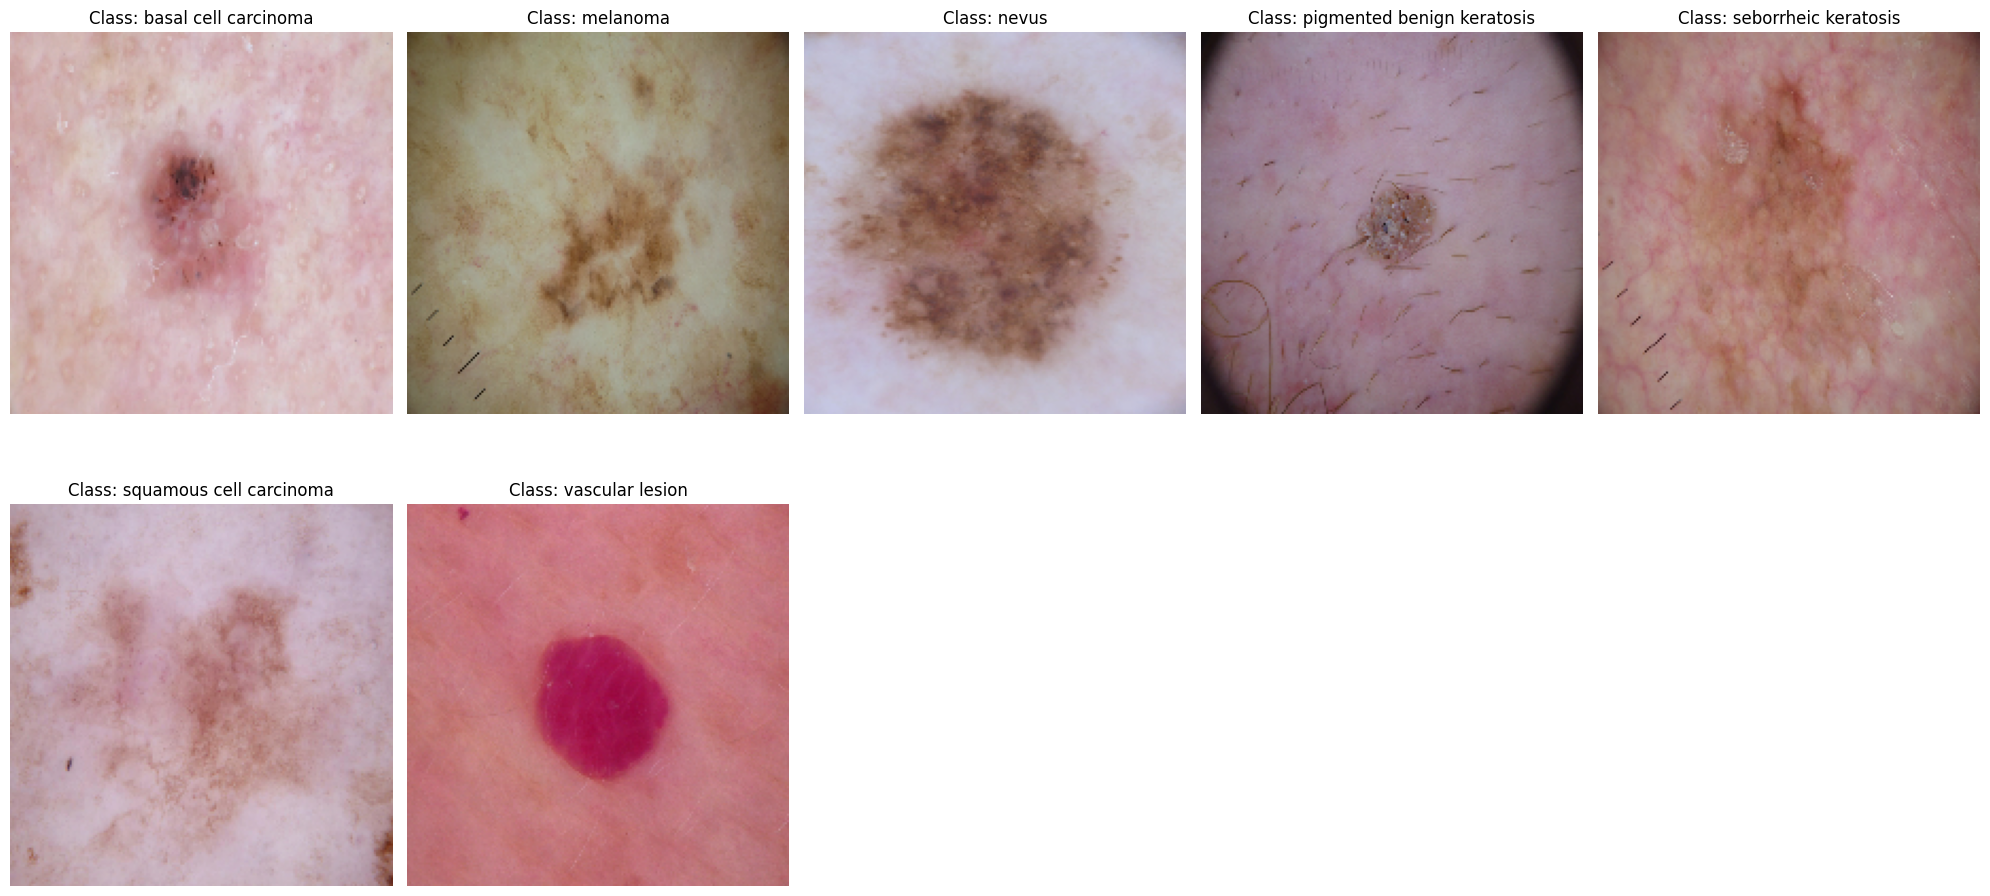

In [33]:
# Visualize Validation Data
val_image_map=generate_image_map(val_ds,batch_num)
plot_sample_images(class_names,val_image_map)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [34]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model 1 - Base Model

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [35]:
### Your code goes here
base_model=Sequential(name="Melanoma_Detection_Model")
# Adding Rescaling layer
base_model.add(layers.Rescaling(1.0/255.0 , offset=0.0 , input_shape=(img_height,img_width,3), name="Rescaling_Layer"))
# First Part
base_model.add(layers.Conv2D(filters=32,kernel_size=(3,3),padding="same",activation="relu",  name="Conv2D_Layer_1"))  # adding first Convolution layer
base_model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_1")) # adding first Max Pooling layer
# Second Part
base_model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu", name="Conv2D_Layer_2")) # adding second Convolution layer
base_model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_2")) # adding second Max Pooling layer
# Flattening the output
base_model.add(layers.Flatten(name="Flatten_Layer"))
# Fully Connected Layer
base_model.add(layers.Dense(units=128,activation="relu",name="FC_Layer_1") )# adding first fully connected layer
base_model.add(layers.Dropout(0.20,name="Dropout_1")) # adding dropouts
# Output Layer
base_model.add(layers.Dense(units=len(class_names),activation="softmax",name="Output_Layer")) # adding output layer

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [36]:
### Todo, choose an appropirate optimiser and loss function
base_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [37]:
# View the summary of all layers
base_model.summary()

Model: "Melanoma_Detection_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Rescaling_Layer (Rescaling)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_1 (Conv2D)              │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_1 (MaxPooling2D)  │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_2 (Conv2D)              │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_2 (MaxPooling2D)  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten_Layer (Flatten)              │ (None, 129600)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_Layer_1 (Dense)                   │ (None, 128)                 │      16,588,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,609,481 (63.36 MB)

 Trainable params: 16,609,481 (63.36 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [38]:
epochs = 20
base_model_history = base_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 155s 320ms/step - accuracy: 0.2002 - loss: 4.5094 - val_accuracy: 0.2908 - val_loss: 1.9800
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.2814 - loss: 1.9607 - val_accuracy: 0.3199 - val_loss: 1.8677
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.3740 - loss: 1.7824 - val_accuracy: 0.4698 - val_loss: 1.5432
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.4440 - loss: 1.5674 - val_accuracy: 0.5056 - val_loss: 1.4944
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.4882 - loss: 1.4575 - val_accuracy: 0.4609 - val_loss: 1.5773
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5256 - loss: 1.3607 - val_accuracy: 0.4855 - val_loss: 1.5358
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5734 - loss: 1.2496 - val_accuracy: 0.5034 - val_loss: 1.4805
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5929 - loss: 1.1658 - val_accuracy: 0.5302 

### Visualizing training results

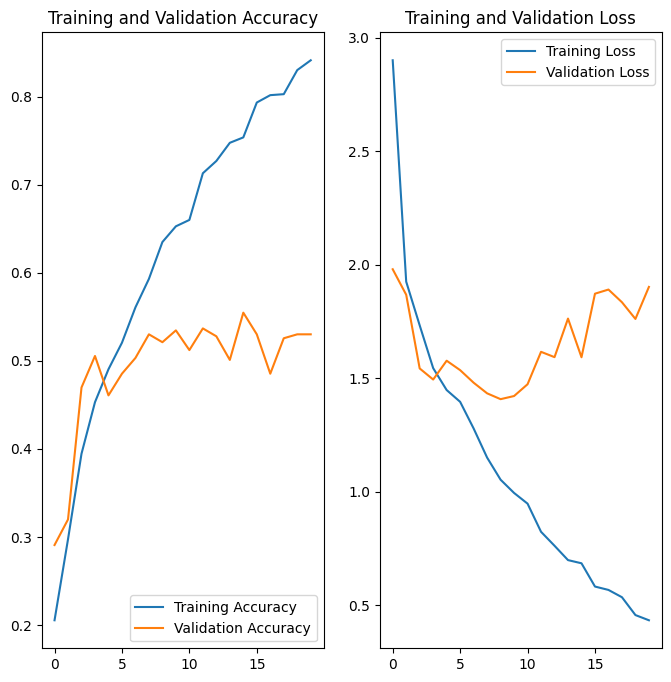

In [39]:
acc = base_model_history.history['accuracy']
val_acc = base_model_history.history['val_accuracy']

loss = base_model_history.history['loss']
val_loss = base_model_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
- The training accuracy steadily improve to 88% by the 20th epoch, indicating that - the model is learning and fitting the training data well.
- The validation accuracy, on the other hand, peaks at around 55% and - then stagnates or decreases by the 20th epoch. This shows that the model - is not generalizing well to unseen data and starts to overfit after a - certain point.
- While the training loss continues to drop, the validation loss increases significantly over time by the 20th epoch.

<b><i>The model is overfitting, as indicated by the widening gap between the training and validation performance</i></b>

## Model 2 - Base Model with Data Augmentation

### Data augmentation

In [40]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
data_augmentation = Sequential([
  layers.RandomFlip("horizontal_and_vertical", seed=123 ),
  layers.RandomRotation(0.2, seed=123),
  layers.RandomZoom(0.2, seed=123),
] , name="Data_Augmentation_Layer")

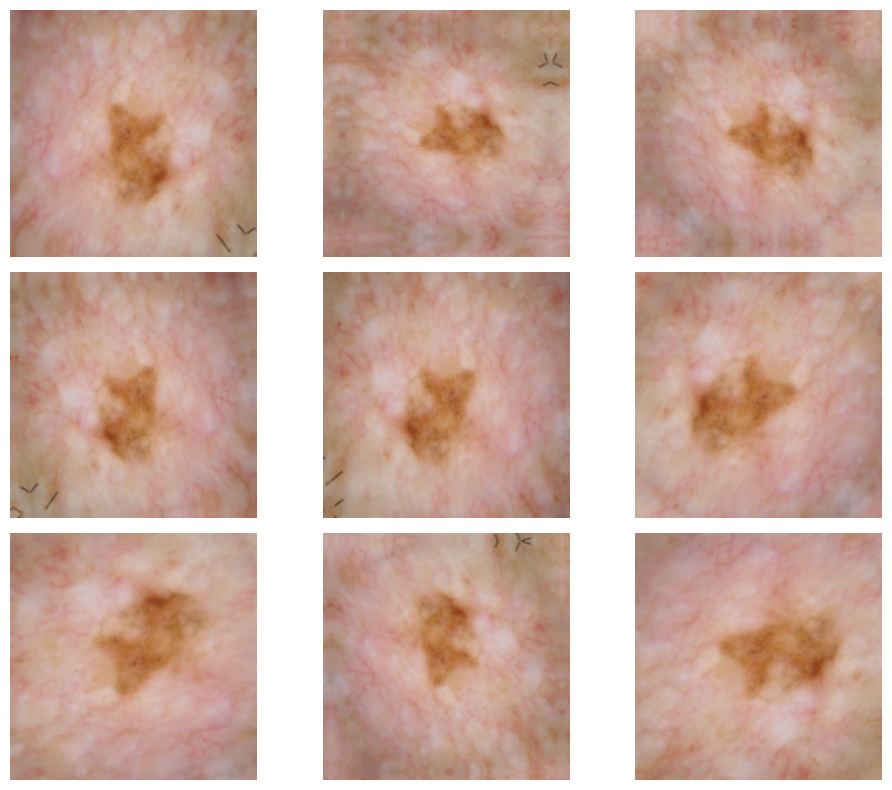

In [41]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
random_num=random.randint(1,11)
# Your code goes here
plt.figure(figsize=(10, 8))
for images, _ in train_ds.skip(random_num-1).take(random_num):
  for i in range(9):
    augmented_images = data_augmentation(images) # data augmenatation
    ax = plt.subplot(3, 3, i + 1) # Create a 3x3 grid for the images
    plt.imshow(augmented_images[random_num].numpy().astype("uint8")) # Display the image
    plt.axis("off") # Turn off the axis
# Show the plot with all images
plt.tight_layout()
plt.show()

### Todo:
### Create the model, compile and train the model


In [42]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

### Your code goes here
aug_layer_model=Sequential(name="Melanoma_Detection_Model")
# Adding Rescaling layer
aug_layer_model.add(layers.Rescaling(1.0/255.0 , offset=0.0 , input_shape=(img_height,img_width,3), name="Rescaling_Layer"))
# Adding Data Augmentation
aug_layer_model.add( data_augmentation )
# First Part
aug_layer_model.add(layers.Conv2D(filters=32,kernel_size=(3,3),padding="same",activation="relu",  name="Conv2D_Layer_1"))  # adding first Convolution layer
aug_layer_model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_1")) # adding first Max Pooling layer
aug_layer_model.add(layers.Dropout(0.20 ,name="Dropout_1") )# adding dropouts
# Second Part
aug_layer_model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu", name="Conv2D_Layer_2")) # adding second Convolution layer
aug_layer_model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_2")) # adding second Max Pooling layer
aug_layer_model.add(layers.Dropout(0.20 ,name="Dropout_2") )# adding dropouts
# Flattening the output
aug_layer_model.add(layers.Flatten(name="Flatten_Layer"))
# Fully Connected Layer
aug_layer_model.add(layers.Dense(units=128,activation="relu",name="FC_Layer_1") )# adding first fully connected layer
aug_layer_model.add(layers.Dropout(0.20,name="Dropout_3")) # adding dropouts
# Output Layer
aug_layer_model.add(layers.Dense(units=len(class_names),activation="softmax",name="Output_Layer")) # adding output layer

### Compiling the model

In [43]:
## Your code goes here
aug_layer_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [44]:
# View the summary of all layers
aug_layer_model.summary()

Model: "Melanoma_Detection_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Rescaling_Layer (Rescaling)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Data_Augmentation_Layer (Sequential) │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_1 (Conv2D)              │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_1 (MaxPooling2D)  │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1 (Dropout)                  │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_2 (Conv2D)              │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_2 (MaxPooling2D)  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_2 (Dropout)                  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten_Layer (Flatten)              │ (None, 129600)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_Layer_1 (Dense)                   │ (None, 128)                 │      16,588,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,609,481 (63.36 MB)

 Trainable params: 16,609,481 (63.36 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [45]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
aug_layer_history = aug_layer_model.fit(train_ds ,
                    batch_size=batch_size ,
                    epochs=epochs,
                    validation_data=val_ds,
                    verbose=1)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.1984 - loss: 3.1963 - val_accuracy: 0.3535 - val_loss: 1.9755
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.3351 - loss: 1.8471 - val_accuracy: 0.3915 - val_loss: 1.9299
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.3738 - loss: 1.7123 - val_accuracy: 0.4452 - val_loss: 1.6817
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.4027 - loss: 1.6504 - val_accuracy: 0.3937 - val_loss: 1.7394
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.4582 - loss: 1.5511 - val_accuracy: 0.5056 - val_loss: 1.5796
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.4862 - loss: 1.4868 - val_accuracy: 0.5011 - val_loss: 1.5643
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.4765 - loss: 1.4872 - val_accuracy: 0.5235 - val_loss: 1.4536
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.4792 - loss: 1.4537 - val_accuracy: 0.4340 - v

### Visualizing the results

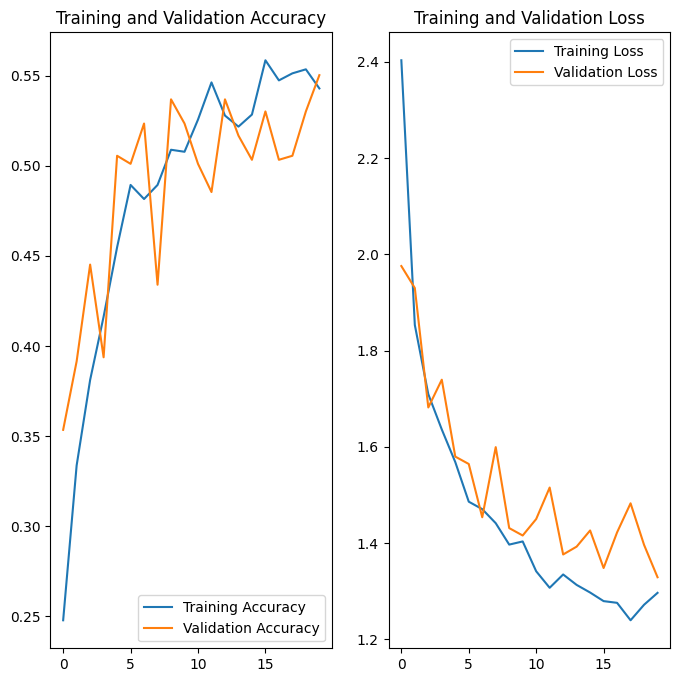

In [46]:
acc = aug_layer_history.history['accuracy']
val_acc = aug_layer_history.history['val_accuracy']

loss = aug_layer_history.history['loss']
val_loss = aug_layer_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Findings:
- The training accuracy and validation accuracy are almost the same but are both quite low, indicating that the model is likely underfitting.
- The training loss is very low, while the validation loss fluctuates significantly.
- These results suggest that the current model is not performing well and requires improvement.
- Additionally, addressing the issue of class imbalance could further - improve the model's performance.

## Model 3 - Base Model with Data Augmentation after fixing Data imbalacing

### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [47]:
## Your code goes here.
list_images = []
for i in class_names:
    list_images.append(len(list(data_dir_train.glob(i+'/*.jpg'))))

data = {'Class Names': class_names, 'Image Count': list_images}
original_df = pd.DataFrame(data)

In [48]:
original_df.head(9)

Class Names  Image Count
0           actinic keratosis          114
1        basal cell carcinoma          376
2              dermatofibroma           95
3                    melanoma          438
4                       nevus          357
5  pigmented benign keratosis          462
6        seborrheic keratosis           77
7     squamous cell carcinoma          181
8             vascular lesion          139

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
Answer - seborrheic keratosis has the least number of samples - 77
#### - Which classes dominate the data in terms proportionate number of samples?
Answer - pigmented benign keratosis dominates the data in terms proportionate number of samples - 462


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [49]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [50]:
path_to_training_dataset="/content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    class_path = path_to_training_dataset + i + '/output'
    # Check if 'output' folder exists and has the required number of images
    if os.path.exists(class_path) and len(os.listdir(class_path)) >= target_sample_size:
        print(f"Augmentation already done for class '{i}', skipping augmentation.")
    else:
        print(f"Augmenting class '{i}' as required samples are not present.")
    # Create an Augmentor pipeline for the class if augmentation is needed
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Augmenting class 'actinic keratosis' as required samples are not present.
Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D4BA424B2E0>: 100%|██████████| 500/500 [00:06<00:00, 75.63 Samples/s]


Augmenting class 'basal cell carcinoma' as required samples are not present.
Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D4B13D5F280>: 100%|██████████| 500/500 [00:06<00:00, 79.22 Samples/s]


Augmenting class 'dermatofibroma' as required samples are not present.
Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D4BA4275180>: 100%|██████████| 500/500 [00:05<00:00, 86.34 Samples/s]


Augmenting class 'melanoma' as required samples are not present.
Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7D4B605CC2B0>: 100%|██████████| 500/500 [00:20<00:00, 24.71 Samples/s]


Augmenting class 'nevus' as required samples are not present.
Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7D4AF87952D0>: 100%|██████████| 500/500 [00:17<00:00, 28.72 Samples/s]


Augmenting class 'pigmented benign keratosis' as required samples are not present.
Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D4B605077C0>: 100%|██████████| 500/500 [00:06<00:00, 82.70 Samples/s]


Augmenting class 'seborrheic keratosis' as required samples are not present.
Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D4BA8ED7BB0>: 100%|██████████| 500/500 [00:09<00:00, 51.86 Samples/s]


Augmenting class 'squamous cell carcinoma' as required samples are not present.
Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D4B60214040>: 100%|██████████| 500/500 [00:05<00:00, 87.47 Samples/s]


Augmenting class 'vascular lesion' as required samples are not present.
Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D4AF8739B10>: 100%|██████████| 500/500 [00:06<00:00, 82.58 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [51]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [52]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000539.jpg_5ca0bc29-2779-4b46-9717-a0aff4415adc.jpg',
 '/content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000508.jpg_797fe893-60dc-47a3-87e0-af7d26e6326b.jpg',
 '/content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000556.jpg_3fe2fd76-887f-49ca-b021-b03cb7e6841e.jpg',
 '/content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0029041.jpg_1bc3b38b-5ce4-4385-b6dd-d969f39c5f32.jpg',
 '/content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus

In [53]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [54]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [55]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df,df2],ignore_index=True)

In [56]:
new_df['Label'].value_counts()

Label
nevus                         500
squamous cell carcinoma       500
basal cell carcinoma          500
seborrheic keratosis          500
pigmented benign keratosis    500
melanoma                      500
dermatofibroma                500
actinic keratosis             500
vascular lesion               500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### **Todo**: Train the model on the data created using Augmentor

In [57]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [58]:
data_dir_train="/content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [59]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset ='validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### **Todo:** Create your model (make sure to include normalization)

#### Create your model

In [60]:
## your code goes here
class_balanced_model = Sequential(name="Melanoma_Detection_Model")

# Adding Rescaling layer
class_balanced_model.add(layers.Rescaling(1.0/255.0, offset=0.0, input_shape=(img_height, img_width, 3), name="Rescaling_Layer"))

# Adding Data Augmentation
class_balanced_model.add(data_augmentation)

# First Part
class_balanced_model.add(layers.Conv2D(filters=32, kernel_size=(3,3), name="Conv2D_Layer_1"))  # adding first Convolution layer
class_balanced_model.add(layers.BatchNormalization(name="BatchNorm_Layer_1"))  # adding normalization
class_balanced_model.add(layers.Activation('relu', name="ReLU_Activation_1"))
class_balanced_model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_1"))  # adding first Max Pooling layer
class_balanced_model.add(layers.Dropout(0.20, name="Dropout_1"))  # adding dropout

# Second Part
class_balanced_model.add(layers.Conv2D(filters=64, kernel_size=(3,3), name="Conv2D_Layer_2"))  # adding second Convolution layer
class_balanced_model.add(layers.BatchNormalization(name="BatchNorm_Layer_2"))  # adding normalization
class_balanced_model.add(layers.Activation('relu', name="ReLU_Activation_2"))
class_balanced_model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_2"))  # adding second Max Pooling layer
class_balanced_model.add(layers.Dropout(0.20, name="Dropout_2"))  # adding dropout

# Flattening the output
class_balanced_model.add(layers.Flatten(name="Flatten_Layer"))

# Fully Connected Layer
class_balanced_model.add(layers.Dense(units=128, name="FC_Layer_1"))
class_balanced_model.add(layers.BatchNormalization(name="BatchNorm_Layer_3"))  # adding normalization
class_balanced_model.add(layers.Activation('relu', name="ReLU_Activation_3"))
class_balanced_model.add(layers.Dropout(0.20, name="Dropout_3"))  # adding dropout

# Output Layer
class_balanced_model.add(layers.Dense(units=len(class_names), activation="softmax", name="Output_Layer"))  # adding output layer

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [61]:
## your code goes here
class_balanced_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [62]:
# View the summary of all layers
class_balanced_model.summary()

Model: "Melanoma_Detection_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Rescaling_Layer (Rescaling)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Data_Augmentation_Layer (Sequential) │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_1 (Conv2D)              │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_1                    │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_1 (Activation)       │ (None, 178, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_1 (MaxPooling2D)  │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1 (Dropout)                  │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_2 (Conv2D)              │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_2                    │ (None, 87, 87, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_2 (Activation)       │ (None, 87, 87, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_2 (MaxPooling2D)  │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_2 (Dropout)                  │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten_Layer (Flatten)              │ (None, 118336)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_Layer_1 (Dense)                   │ (None, 128)                 │      15,147,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_3                    │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_3 (Activation)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,168,585 (57.86 MB)

 Trainable params: 15,168,137 (57.86 MB)

 Non-trainable params: 448 (1.75 KB)

#### **Todo:**  Train your model

In [63]:
epochs = 30
## Your code goes here, use 30 epochs.
class_balanced_history = class_balanced_model.fit(train_ds ,
                    batch_size=batch_size ,
                    epochs=epochs,
                    validation_data=val_ds,
                    verbose=1)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 22s 106ms/step - accuracy: 0.3377 - loss: 1.8613 - val_accuracy: 0.1069 - val_loss: 2.8295
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 102ms/step - accuracy: 0.4730 - loss: 1.4052 - val_accuracy: 0.2042 - val_loss: 2.5033
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step - accuracy: 0.4994 - loss: 1.3341 - val_accuracy: 0.2799 - val_loss: 1.9046
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 102ms/step - accuracy: 0.5251 - loss: 1.2468 - val_accuracy: 0.2428 - val_loss: 2.5732
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step - accuracy: 0.5449 - loss: 1.1945 - val_accuracy: 0.4907 - val_loss: 1.2754
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step - accuracy: 0.5661 - loss: 1.1505 - val_accuracy: 0.3786 - val_loss: 1.8229
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 102ms/step - accuracy: 0.5723 - loss: 1.1376 - val_accuracy: 0.5278 - val_loss: 1.2047
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step - accuracy: 0.5832 - loss: 1

#### **Todo:**  Visualize the model results

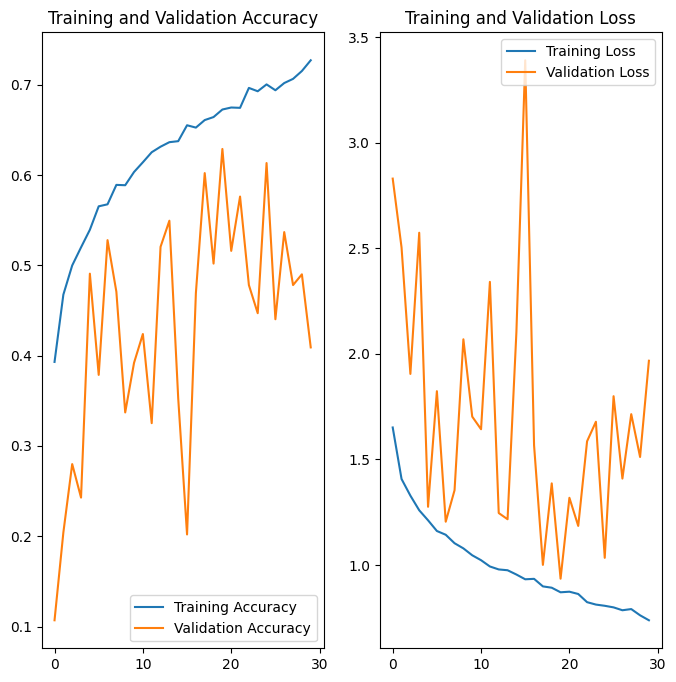

In [64]:
acc = class_balanced_history.history['accuracy']
val_acc = class_balanced_history.history['val_accuracy']

loss = class_balanced_history.history['loss']
val_loss = class_balanced_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 4 - Include Callbacks and adjust Dropouts ( gradually increase dropout percentages )

In [65]:
## your code goes here
lr_control_model = Sequential(name="Melanoma_Detection_Model")

# Adding Rescaling layer
lr_control_model.add(layers.Rescaling(1.0/255.0, offset=0.0, input_shape=(img_height, img_width, 3), name="Rescaling_Layer"))

# Adding Data Augmentation
lr_control_model.add(data_augmentation)

# First Part
lr_control_model.add(layers.Conv2D(filters=32, kernel_size=(3,3),  name="Conv2D_Layer_1"))  # adding first Convolution layer
lr_control_model.add(layers.BatchNormalization(name="BatchNorm_Layer_1"))  # adding normalization
lr_control_model.add(layers.Activation('relu', name="ReLU_Activation_1"))
lr_control_model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_1"))  # adding first Max Pooling layer
lr_control_model.add(layers.Dropout(0.25, name="Dropout_1"))  # adding dropout

# Second Part
lr_control_model.add(layers.Conv2D(filters=64, kernel_size=(3,3), name="Conv2D_Layer_2"))  # adding second Convolution layer
lr_control_model.add(layers.BatchNormalization(name="BatchNorm_Layer_2"))  # adding normalization
lr_control_model.add(layers.Activation('relu', name="ReLU_Activation_2"))
lr_control_model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_2"))  # adding second Max Pooling layer
lr_control_model.add(layers.Dropout(0.30, name="Dropout_2"))  # adding dropout

# Flattening the output
lr_control_model.add(layers.Flatten(name="Flatten_Layer"))

# Fully Connected Layer
lr_control_model.add(layers.Dense(units=128, name="FC_Layer_1"))
lr_control_model.add(layers.BatchNormalization(name="BatchNorm_Layer_3"))  # adding normalization
lr_control_model.add(layers.Activation('relu', name="ReLU_Activation_3"))
lr_control_model.add(layers.Dropout(0.40, name="Dropout_3"))  # adding dropout

# Output Layer
lr_control_model.add(layers.Dense(units=len(class_names), activation="softmax", name="Output_Layer"))  # adding output layer

# Compile the model
lr_control_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Set callbacks
learn_control = ReduceLROnPlateau(monitor='val_accuracy',
                                  patience=3,
                                  verbose=1,
                                  factor=0.1,
                                  min_lr=1e-7)

# View the summary of all layers
lr_control_model.summary()

Model: "Melanoma_Detection_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Rescaling_Layer (Rescaling)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Data_Augmentation_Layer (Sequential) │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_1 (Conv2D)              │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_1                    │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_1 (Activation)       │ (None, 178, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_1 (MaxPooling2D)  │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1 (Dropout)                  │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_2 (Conv2D)              │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_2                    │ (None, 87, 87, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_2 (Activation)       │ (None, 87, 87, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_2 (MaxPooling2D)  │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_2 (Dropout)                  │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten_Layer (Flatten)              │ (None, 118336)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_Layer_1 (Dense)                   │ (None, 128)                 │      15,147,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_3                    │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_3 (Activation)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,168,585 (57.86 MB)

 Trainable params: 15,168,137 (57.86 MB)

 Non-trainable params: 448 (1.75 KB)

Train the model

In [66]:
epochs = 30
lr_control_history = lr_control_model.fit(train_ds ,
                    batch_size=batch_size ,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=[learn_control],
                    verbose=1)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - accuracy: 0.3184 - loss: 2.0335 - val_accuracy: 0.1158 - val_loss: 2.8084 - learning_rate: 0.0010
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step - accuracy: 0.4259 - loss: 1.4972 - val_accuracy: 0.1782 - val_loss: 2.2477 - learning_rate: 0.0010
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step - accuracy: 0.4772 - loss: 1.3852 - val_accuracy: 0.3935 - val_loss: 1.5687 - learning_rate: 0.0010
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step - accuracy: 0.5003 - loss: 1.3173 - val_accuracy: 0.2873 - val_loss: 1.9869 - learning_rate: 0.0010
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 102ms/step - accuracy: 0.5162 - loss: 1.2518 - val_accuracy: 0.5212 - val_loss: 1.3019 - learning_rate: 0.0010
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step - accuracy: 0.5412 - loss: 1.1958 - val_accuracy: 0.3549 - val_loss: 1.8170 - learning_rate: 0.0010
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step - accuracy: 0.5

Visualize the model results

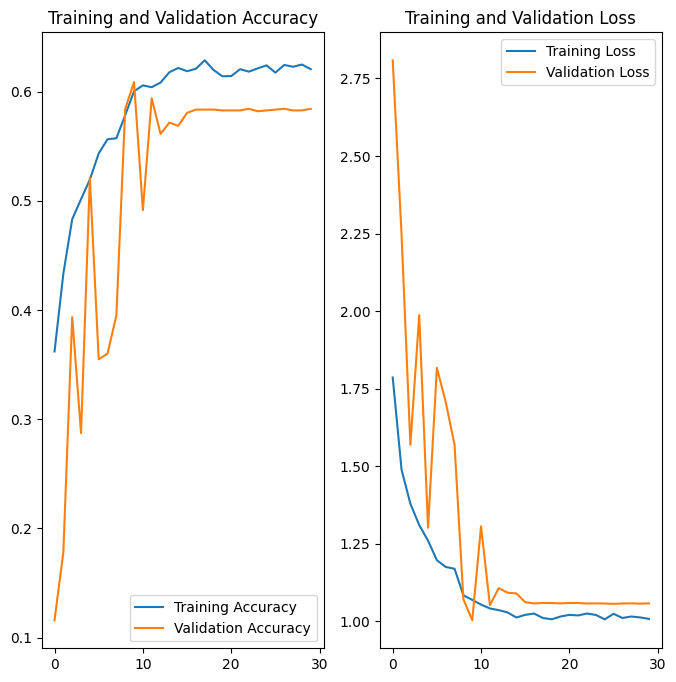

In [67]:
acc = lr_control_history.history['accuracy']
val_acc = lr_control_history.history['val_accuracy']

loss = lr_control_history.history['loss']
val_loss = lr_control_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

In Model 1, we observed significant overfitting, with high training accuracy (0.84) but much lower validation accuracy (0.55). Adding data augmentation in Model 2 helped reduce the gap between training and validation accuracy, but underfitting became a concern. Model 3, with class rebalancing, further reduced overfitting but slightly hindered validation performance.

Model 4, which introduced controlled learning rate, showed improved generalization, as indicated by a more balanced train and validation accuracy (0.63 vs. 0.61). Overall, class rebalancing and learning rate control contributed positively to the model’s stability.

## Model 5 - Let's try with little increased Learning rate and also include Callbacks

Create the Model

In [68]:
## your code goes here
increased_lr_control_model = Sequential(name="Melanoma_Detection_Model")

# Adding Rescaling layer
increased_lr_control_model.add(layers.Rescaling(1.0/255.0, offset=0.0, input_shape=(img_height, img_width, 3), name="Rescaling_Layer"))

# Adding Data Augmentation
increased_lr_control_model.add(data_augmentation)

# First Part
increased_lr_control_model.add(layers.Conv2D(filters=32, kernel_size=(3,3), name="Conv2D_Layer_1"))  # adding first Convolution layer
increased_lr_control_model.add(layers.BatchNormalization(name="BatchNorm_Layer_1"))  # adding normalization
increased_lr_control_model.add(layers.Activation('relu', name="ReLU_Activation_1"))
increased_lr_control_model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_1"))  # adding first Max Pooling layer
increased_lr_control_model.add(layers.Dropout(0.25, name="Dropout_1"))  # adding dropout

# Second Part
increased_lr_control_model.add(layers.Conv2D(filters=64, kernel_size=(3,3), name="Conv2D_Layer_2"))  # adding second Convolution layer
increased_lr_control_model.add(layers.BatchNormalization(name="BatchNorm_Layer_2"))  # adding normalization
increased_lr_control_model.add(layers.Activation('relu', name="ReLU_Activation_2"))
increased_lr_control_model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_2"))  # adding second Max Pooling layer
increased_lr_control_model.add(layers.Dropout(0.30, name="Dropout_2"))  # adding dropout

# Flattening the output
increased_lr_control_model.add(layers.Flatten(name="Flatten_Layer"))

# Fully Connected Layer
increased_lr_control_model.add(layers.Dense(units=128, name="FC_Layer_1"))
increased_lr_control_model.add(layers.BatchNormalization(name="BatchNorm_Layer_3"))  # adding normalization
increased_lr_control_model.add(layers.Activation('relu', name="ReLU_Activation_3"))
increased_lr_control_model.add(layers.Dropout(0.40, name="Dropout_3"))  # adding dropout

# Output Layer
increased_lr_control_model.add(layers.Dense(units=len(class_names), activation="softmax", name="Output_Layer"))  # adding output layer

# Compile the model
increased_lr_control_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), # Reduce learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Set callbacks
learn_control = ReduceLROnPlateau(monitor='val_accuracy',
                                  patience=3,
                                  verbose=1,
                                  factor=0.1,
                                  min_lr=1e-7)

# View the summary of all layers
increased_lr_control_model.summary()

Model: "Melanoma_Detection_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Rescaling_Layer (Rescaling)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Data_Augmentation_Layer (Sequential) │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_1 (Conv2D)              │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_1                    │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_1 (Activation)       │ (None, 178, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_1 (MaxPooling2D)  │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1 (Dropout)                  │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_2 (Conv2D)              │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_2                    │ (None, 87, 87, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_2 (Activation)       │ (None, 87, 87, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_2 (MaxPooling2D)  │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_2 (Dropout)                  │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten_Layer (Flatten)              │ (None, 118336)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_Layer_1 (Dense)                   │ (None, 128)                 │      15,147,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_3                    │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_3 (Activation)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,168,585 (57.86 MB)

 Trainable params: 15,168,137 (57.86 MB)

 Non-trainable params: 448 (1.75 KB)

Train the model

In [69]:
epochs = 30
increased_lr_control_history = increased_lr_control_model.fit(train_ds ,
                    batch_size=batch_size ,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=[learn_control],
                    verbose=1)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - accuracy: 0.3060 - loss: 1.9283 - val_accuracy: 0.1552 - val_loss: 2.1681 - learning_rate: 0.0100
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step - accuracy: 0.4086 - loss: 1.5068 - val_accuracy: 0.2962 - val_loss: 1.8936 - learning_rate: 0.0100
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - accuracy: 0.4484 - loss: 1.4323 - val_accuracy: 0.4039 - val_loss: 1.5918 - learning_rate: 0.0100
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step - accuracy: 0.4640 - loss: 1.3816 - val_accuracy: 0.4001 - val_loss: 1.5582 - learning_rate: 0.0100
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step - accuracy: 0.4786 - loss: 1.3313 - val_accuracy: 0.4276 - val_loss: 1.5316 - learning_rate: 0.0100
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step - accuracy: 0.4965 - loss: 1.2918 - val_accuracy: 0.3779 - val_loss: 1.6718 - learning_rate: 0.0100
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step - accuracy: 0.5

Visualize the model results

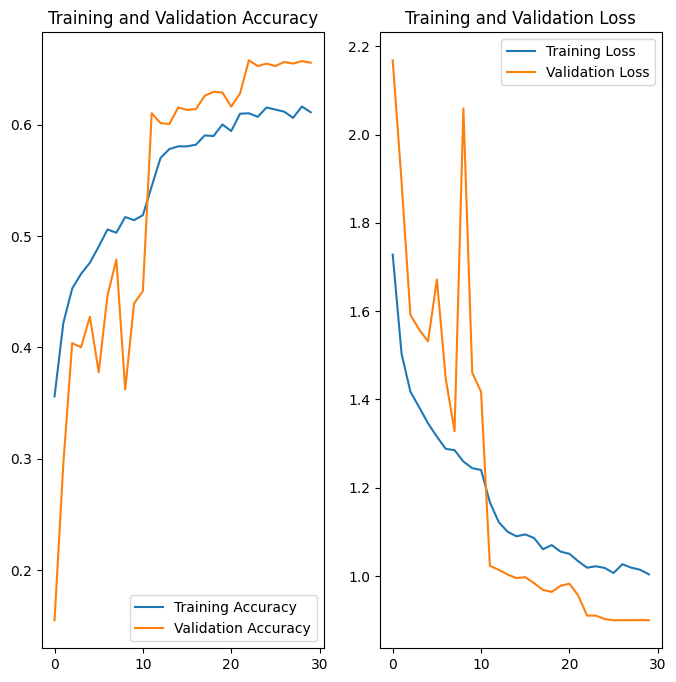

In [70]:
acc = increased_lr_control_history.history['accuracy']
val_acc = increased_lr_control_history.history['val_accuracy']

loss = increased_lr_control_history.history['loss']
val_loss = increased_lr_control_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 6 - Default Learning Rate and increased Epoch Value

In [71]:
## your code goes here
more_epoch_model = Sequential(name="Melanoma_Detection_Model")

# Adding Rescaling layer
more_epoch_model.add(layers.Rescaling(1.0/255.0, offset=0.0, input_shape=(img_height, img_width, 3), name="Rescaling_Layer"))

# Adding Data Augmentation
more_epoch_model.add(data_augmentation)

# First Part
more_epoch_model.add(layers.Conv2D(filters=32, kernel_size=(3,3), name="Conv2D_Layer_1"))  # adding first Convolution layer
more_epoch_model.add(layers.BatchNormalization(name="BatchNorm_Layer_1"))  # adding normalization
more_epoch_model.add(layers.Activation('relu', name="ReLU_Activation_1"))
more_epoch_model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_1"))  # adding first Max Pooling layer
more_epoch_model.add(layers.Dropout(0.25, name="Dropout_1"))  # adding dropout

# Second Part
more_epoch_model.add(layers.Conv2D(filters=64, kernel_size=(3,3), name="Conv2D_Layer_2"))  # adding second Convolution layer
more_epoch_model.add(layers.BatchNormalization(name="BatchNorm_Layer_2"))  # adding normalization
more_epoch_model.add(layers.Activation('relu', name="ReLU_Activation_2"))
more_epoch_model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_2"))  # adding second Max Pooling layer
more_epoch_model.add(layers.Dropout(0.30, name="Dropout_2"))  # adding dropout

# Flattening the output
more_epoch_model.add(layers.Flatten(name="Flatten_Layer"))

# Fully Connected Layer
more_epoch_model.add(layers.Dense(units=128, name="FC_Layer_1"))
more_epoch_model.add(layers.BatchNormalization(name="BatchNorm_Layer_3"))  # adding normalization
more_epoch_model.add(layers.Activation('relu', name="ReLU_Activation_3"))
more_epoch_model.add(layers.Dropout(0.40, name="Dropout_3"))  # adding dropout

# Output Layer
more_epoch_model.add(layers.Dense(units=len(class_names), activation="softmax", name="Output_Layer"))  # adding output layer

# Compile the model
more_epoch_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Set callbacks
learn_control = ReduceLROnPlateau(monitor='val_accuracy',
                                  patience=3,
                                  verbose=1,
                                  factor=0.1,
                                  min_lr=1e-7)

# View the summary of all layers
more_epoch_model.summary()

Model: "Melanoma_Detection_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Rescaling_Layer (Rescaling)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Data_Augmentation_Layer (Sequential) │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_1 (Conv2D)              │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_1                    │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_1 (Activation)       │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_1 (MaxPooling2D)  │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1 (Dropout)                  │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_2 (Conv2D)              │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_2                    │ (None, 90, 90, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_2 (Activation)       │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_2 (MaxPooling2D)  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_2 (Dropout)                  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten_Layer (Flatten)              │ (None, 129600)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_Layer_1 (Dense)                   │ (None, 128)                 │      16,588,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_3                    │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_3 (Activation)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,610,377 (63.36 MB)

 Trainable params: 16,609,929 (63.36 MB)

 Non-trainable params: 448 (1.75 KB)

Train the model

In [72]:
epochs = 50
more_epoch_history = more_epoch_model.fit(train_ds ,
                    batch_size=batch_size ,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=[learn_control],
                    verbose=1)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.3233 - loss: 1.9682 - val_accuracy: 0.1180 - val_loss: 2.7025 - learning_rate: 0.0010
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - accuracy: 0.4408 - loss: 1.4808 - val_accuracy: 0.1863 - val_loss: 2.6240 - learning_rate: 0.0010
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.4745 - loss: 1.3884 - val_accuracy: 0.2205 - val_loss: 2.0318 - learning_rate: 0.0010
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.4944 - loss: 1.3207 - val_accuracy: 0.4388 - val_loss: 1.4734 - learning_rate: 0.0010
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - accuracy: 0.5212 - loss: 1.2596 - val_accuracy: 0.3860 - val_loss: 1.6004 - learning_rate: 0.0010
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.5356 - loss: 1.2317 - val_accuracy: 0.3764 - val_loss: 1.6365 - learning_rate: 0.0010
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.5

Visualize the model results

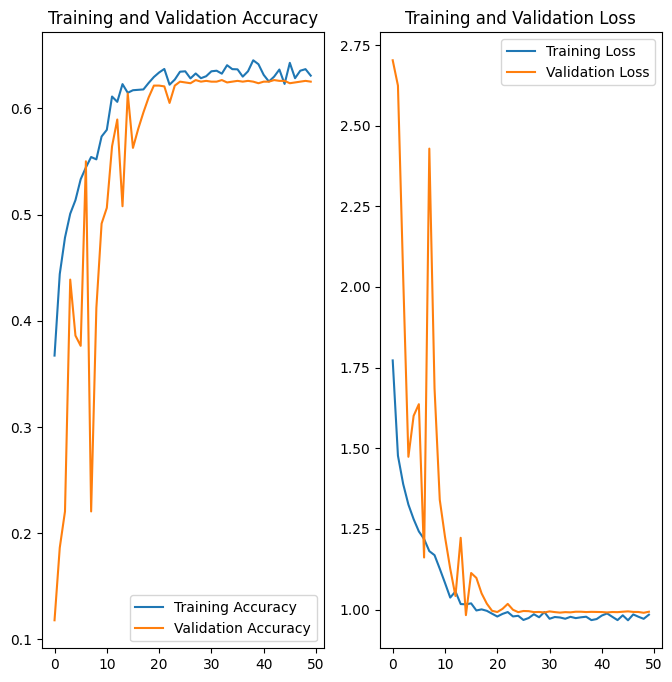

In [73]:
acc = more_epoch_history.history['accuracy']
val_acc = more_epoch_history.history['val_accuracy']

loss = more_epoch_history.history['loss']
val_loss = more_epoch_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 7 - Create more layers and adjust dropuouts

Create the Model

In [84]:
# Create the Model
model_morelayers = Sequential(name="Melanoma_Detection_Model_More_Layers")

# Adding Rescaling layer
model_morelayers.add(layers.Rescaling(1.0/255.0, offset=0.0, input_shape=(img_height, img_width, 3), name="Rescaling_Layer"))

# Adding Data Augmentation
model_morelayers.add(data_augmentation)

# First Part
model_morelayers.add(layers.Conv2D(filters=32, kernel_size=(3,3), name="Conv2D_Layer_32F"))  # adding first Convolution layer
model_morelayers.add(layers.BatchNormalization(name="BatchNorm_Layer_1"))  # adding normalization
model_morelayers.add(layers.Activation('relu', name="ReLU_Activation_1"))
model_morelayers.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_1"))  # adding first Max Pooling layer

# Second Part
model_morelayers.add(layers.Conv2D(filters=64, kernel_size=(3,3), name="Conv2D_Layer_64F"))  # adding second Convolution layer
model_morelayers.add(layers.BatchNormalization(name="BatchNorm_Layer_2"))  # adding normalization
model_morelayers.add(layers.Activation('relu', name="ReLU_Activation_2"))
model_morelayers.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_2"))  # adding second Max Pooling layer

# Third Part
model_morelayers.add(layers.Conv2D(filters=128,kernel_size=(3,3), name="Conv2D_Layer_128F")) # adding third Convolution layer
model_morelayers.add(layers.BatchNormalization(name="BatchNorm_Layer_3"))  # adding normalization
model_morelayers.add(layers.Activation('relu', name="ReLU_Activation_3"))
model_morelayers.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_3")) # adding third Max Pooling layer
model_morelayers.add(layers.Dropout(0.30 ,name="Dropout_1") )# adding dropouts

# Fouth Part
model_morelayers.add(layers.Conv2D(filters=256,kernel_size=(3,3), name="Conv2D_Layer_256F")) # adding third Convolution layer
model_morelayers.add(layers.BatchNormalization(name="BatchNorm_Layer_4"))  # adding normalization
model_morelayers.add(layers.Activation('relu', name="ReLU_Activation_4"))
model_morelayers.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_4")) # adding third Max Pooling layer
model_morelayers.add(layers.Dropout(0.50 ,name="Dropout_2") )# adding dropouts

# Flattening the output
model_morelayers.add(layers.Flatten(name="Flatten_Layer"))

# Fully Connected Layer
model_morelayers.add(layers.Dense(units=256, name="FC_Layer_256N"))
model_morelayers.add(layers.BatchNormalization(name="BatchNorm_Layer_5"))  # adding normalization
model_morelayers.add(layers.Activation('relu', name="ReLU_Activation_5"))
model_morelayers.add(layers.Dropout(0.50, name="Dropout_3"))  # adding dropout

# Fully Connected Layer
model_morelayers.add(layers.Dense(units=128, name="FC_Layer_128N"))
model_morelayers.add(layers.BatchNormalization(name="BatchNorm_Layer_6"))  # adding normalization
model_morelayers.add(layers.Activation('relu', name="ReLU_Activation_6"))
model_morelayers.add(layers.Dropout(0.50, name="Dropout_4"))  # adding dropout

# Fully Connected Layer
model_morelayers.add(layers.Dense(units=64, name="FC_Layer_64N"))
model_morelayers.add(layers.BatchNormalization(name="BatchNorm_Layer_7"))  # adding normalization
model_morelayers.add(layers.Activation('relu', name="ReLU_Activation_7"))
model_morelayers.add(layers.Dropout(0.50, name="Dropout_5"))  # adding dropout

# Output Layer
model_morelayers.add(layers.Dense(units=len(class_names), activation="softmax", name="Output_Layer"))  # adding output layer

# Compile the model
model_morelayers.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Set callbacks
learn_control = ReduceLROnPlateau(monitor='val_accuracy',
                                  patience=3,
                                  verbose=1,
                                  factor=0.1,
                                  min_lr=1e-7)

# View the summary of all layers
model_morelayers.summary()

Model: "Melanoma_Detection_Model_More_Layers"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Rescaling_Layer (Rescaling)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Data_Augmentation_Layer (Sequential) │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_32F (Conv2D)            │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_1                    │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_1 (Activation)       │ (None, 178, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_1 (MaxPooling2D)  │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_64F (Conv2D)            │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_2                    │ (None, 87, 87, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_2 (Activation)       │ (None, 87, 87, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_2 (MaxPooling2D)  │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_128F (Conv2D)           │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_3                    │ (None, 41, 41, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_3 (Activation)       │ (None, 41, 41, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_3 (MaxPooling2D)  │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1 (Dropout)                  │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_256F (Conv2D)           │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_4                    │ (None, 18, 18, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_4 (Activation)       │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_4 (MaxPooling2D)  │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,742,537 (21.91 MB)

 Trainable params: 5,740,681 (21.90 MB)

 Non-trainable params: 1,856 (7.25 KB)

Train the model

In [85]:
epochs = 30
history_morelayers = model_morelayers.fit(train_ds ,
                    batch_size=batch_size ,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=[learn_control],
                    verbose=1)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 25s 115ms/step - accuracy: 0.1703 - loss: 2.4325 - val_accuracy: 0.1151 - val_loss: 2.3007 - learning_rate: 0.0010
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 113ms/step - accuracy: 0.3335 - loss: 1.8112 - val_accuracy: 0.1321 - val_loss: 2.4420 - learning_rate: 0.0010
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step - accuracy: 0.3492 - loss: 1.6801 - val_accuracy: 0.3697 - val_loss: 1.6533 - learning_rate: 0.0010
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step - accuracy: 0.3910 - loss: 1.6013 - val_accuracy: 0.4150 - val_loss: 1.5476 - learning_rate: 0.0010
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step - accuracy: 0.4171 - loss: 1.5245 - val_accuracy: 0.3036 - val_loss: 2.3139 - learning_rate: 0.0010
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 114ms/step - accuracy: 0.4223 - loss: 1.5126 - val_accuracy: 0.2390 - val_loss: 1.8895 - learning_rate: 0.0010
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.437

Visualize the model results

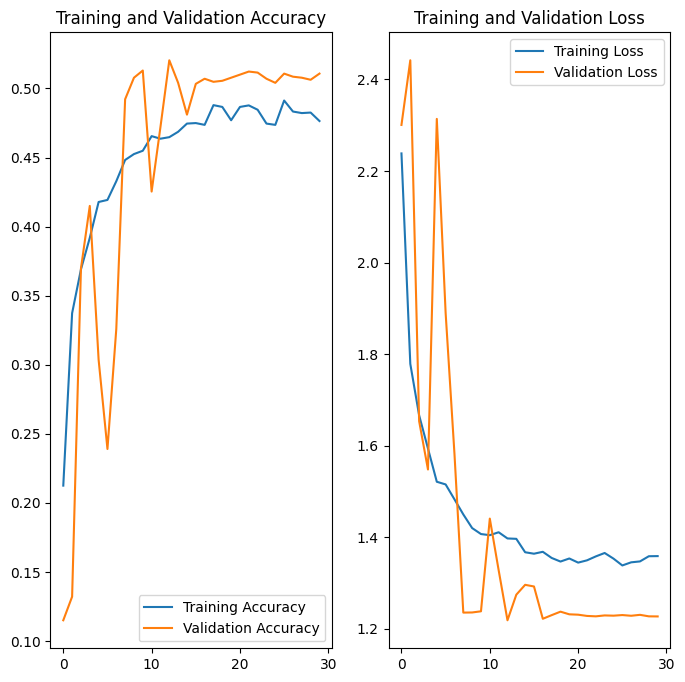

In [86]:
acc = history_morelayers.history['accuracy']
val_acc = history_morelayers.history['val_accuracy']

loss = history_morelayers.history['loss']
val_loss = history_morelayers.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 8 - Remove dropuout layers and check

Create the Model

In [77]:
# Create the Model
less_dropout_model = Sequential(name="Melanoma_Detection_Model_More_Layers")

# Adding Rescaling layer
less_dropout_model.add(layers.Rescaling(1.0/255.0, offset=0.0, input_shape=(img_height, img_width, 3), name="Rescaling_Layer"))

# Adding Data Augmentation
less_dropout_model.add(data_augmentation)

# First Part
less_dropout_model.add(layers.Conv2D(filters=32, kernel_size=(3,3), name="Conv2D_Layer_32F"))  # adding first Convolution layer
less_dropout_model.add(layers.BatchNormalization(name="BatchNorm_Layer_1"))  # adding normalization
less_dropout_model.add(layers.Activation('relu', name="ReLU_Activation_1"))
less_dropout_model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_1"))  # adding first Max Pooling layer

# Second Part
less_dropout_model.add(layers.Conv2D(filters=64, kernel_size=(3,3), name="Conv2D_Layer_64F"))  # adding second Convolution layer
less_dropout_model.add(layers.BatchNormalization(name="BatchNorm_Layer_2"))  # adding normalization
less_dropout_model.add(layers.Activation('relu', name="ReLU_Activation_2"))
less_dropout_model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_2"))  # adding second Max Pooling layer

# Third Part
less_dropout_model.add(layers.Conv2D(filters=128,kernel_size=(3,3), name="Conv2D_Layer_128F")) # adding third Convolution layer
less_dropout_model.add(layers.BatchNormalization(name="BatchNorm_Layer_3"))  # adding normalization
less_dropout_model.add(layers.Activation('relu', name="ReLU_Activation_3"))
less_dropout_model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_3")) # adding third Max Pooling layer

# Fouth Part
less_dropout_model.add(layers.Conv2D(filters=256,kernel_size=(3,3), name="Conv2D_Layer_256F")) # adding third Convolution layer
less_dropout_model.add(layers.BatchNormalization(name="BatchNorm_Layer_4"))  # adding normalization
less_dropout_model.add(layers.Activation('relu', name="ReLU_Activation_4"))
less_dropout_model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_4")) # adding third Max Pooling layer
less_dropout_model.add(layers.Dropout(0.50 ,name="Dropout_1") )# adding dropouts

# Flattening the output
less_dropout_model.add(layers.Flatten(name="Flatten_Layer"))

# Fully Connected Layer
less_dropout_model.add(layers.Dense(units=256, name="FC_Layer_256N"))
less_dropout_model.add(layers.BatchNormalization(name="BatchNorm_Layer_5"))  # adding normalization
less_dropout_model.add(layers.Activation('relu', name="ReLU_Activation_5"))
less_dropout_model.add(layers.Dropout(0.25, name="Dropout_3"))  # adding dropout

# Fully Connected Layer
less_dropout_model.add(layers.Dense(units=128, name="FC_Layer_128N"))
less_dropout_model.add(layers.BatchNormalization(name="BatchNorm_Layer_6"))  # adding normalization
less_dropout_model.add(layers.Activation('relu', name="ReLU_Activation_6"))
less_dropout_model.add(layers.Dropout(0.25, name="Dropout_4"))  # adding dropout

# Fully Connected Layer
less_dropout_model.add(layers.Dense(units=64, name="FC_Layer_64N"))
less_dropout_model.add(layers.BatchNormalization(name="BatchNorm_Layer_7"))  # adding normalization
less_dropout_model.add(layers.Activation('relu', name="ReLU_Activation_7"))
less_dropout_model.add(layers.Dropout(0.25, name="Dropout_5"))  # adding dropout

# Output Layer
less_dropout_model.add(layers.Dense(units=len(class_names), activation="softmax", name="Output_Layer"))  # adding output layer

# Compile the model
less_dropout_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Set callbacks
learn_control = ReduceLROnPlateau(monitor='val_accuracy',
                                  patience=3,
                                  verbose=1,
                                  factor=0.1,
                                  min_lr=1e-7)

# View the summary of all layers
less_dropout_model.summary()

Model: "Melanoma_Detection_Model_More_Layers"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Rescaling_Layer (Rescaling)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Data_Augmentation_Layer (Sequential) │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_32F (Conv2D)            │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_1                    │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_1 (Activation)       │ (None, 178, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_1 (MaxPooling2D)  │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_64F (Conv2D)            │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_2                    │ (None, 87, 87, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_2 (Activation)       │ (None, 87, 87, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_2 (MaxPooling2D)  │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_128F (Conv2D)           │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_3                    │ (None, 41, 41, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_3 (Activation)       │ (None, 41, 41, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_3 (MaxPooling2D)  │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_256F (Conv2D)           │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_4                    │ (None, 18, 18, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_4 (Activation)       │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_4 (MaxPooling2D)  │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1 (Dropout)                  │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,742,537 (21.91 MB)

 Trainable params: 5,740,681 (21.90 MB)

 Non-trainable params: 1,856 (7.25 KB)

Train the model

In [78]:
epochs = 30
less_dropout_history = less_dropout_model.fit(train_ds ,
                    batch_size=batch_size ,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=[learn_control],
                    verbose=1)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 24s 114ms/step - accuracy: 0.2806 - loss: 2.0058 - val_accuracy: 0.1151 - val_loss: 2.4753 - learning_rate: 0.0010
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step - accuracy: 0.4156 - loss: 1.5445 - val_accuracy: 0.1596 - val_loss: 2.3630 - learning_rate: 0.0010
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 113ms/step - accuracy: 0.4456 - loss: 1.4472 - val_accuracy: 0.3623 - val_loss: 1.6962 - learning_rate: 0.0010
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step - accuracy: 0.4834 - loss: 1.3742 - val_accuracy: 0.4425 - val_loss: 1.4293 - learning_rate: 0.0010
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step - accuracy: 0.4991 - loss: 1.3127 - val_accuracy: 0.4232 - val_loss: 1.9441 - learning_rate: 0.0010
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step - accuracy: 0.5002 - loss: 1.2837 - val_accuracy: 0.5442 - val_loss: 1.1660 - learning_rate: 0.0010
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step - accuracy: 0.5

Visualize the model results

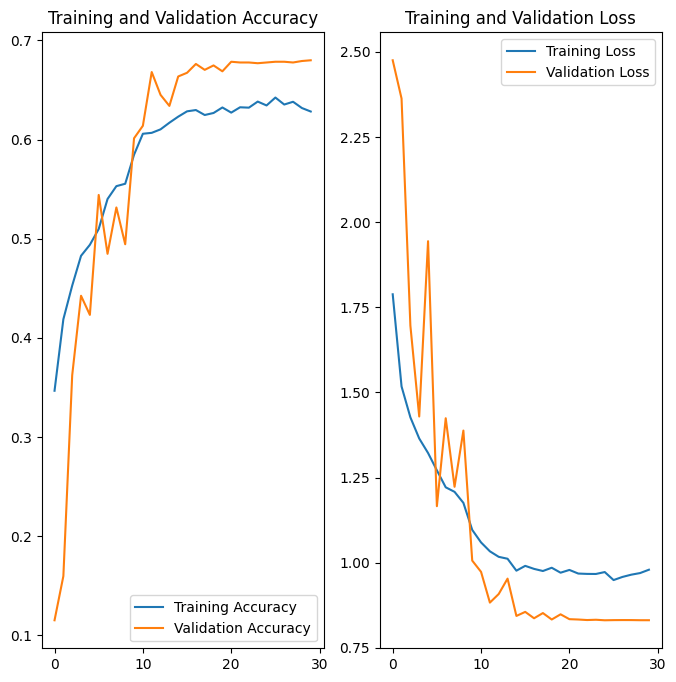

In [79]:
acc = less_dropout_history.history['accuracy']
val_acc = less_dropout_history.history['val_accuracy']

loss = less_dropout_history.history['loss']
val_loss = less_dropout_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Prediction and Evaluation on Test Set

Test dataset creation

In [80]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,  # Path to the test data directory
    labels='inferred',  # Automatically infer labels from subdirectories
    label_mode='int',  # Labels will be integers
    class_names=None,  # Infer class names automatically
    color_mode='rgb',  # Images are in RGB
    batch_size=32,  # Batch size
    image_size=(img_height, img_width),  # Image size to resize to
    shuffle=False,  # Do not shuffle test data
    interpolation='bilinear',  # Interpolation method
    follow_links=False  # Follow symbolic links
)


Found 118 files belonging to 9 classes.


Prediction on Train Test Validation Set

In [87]:
# Function to evaluate accuracy on test data
def evaluate_accuracy(model_inp, data_inp):
    loss, accuracy = model_inp.evaluate(data_inp, verbose=0)  # Suppress verbose output
    return accuracy

# Dictionary containing models and their training histories
model_dict = {
    "Base Model": [base_model, base_model_history],
    "Base Model + Augmented Layers": [aug_layer_model, aug_layer_history],
    "Base Model + Augmented Layers + Balanced Class": [class_balanced_model, class_balanced_history],
    "Base Model + Augmented Layers + Balanced Class + Controlled LR": [lr_control_model, lr_control_history],
    "Base Model + Augmented Layers + Balanced Class + Increased / Controlled LR": [increased_lr_control_model, increased_lr_control_history],
    "Base Model + Augmented Layers + Balanced Class + Controlled LR + More Epochs": [more_epoch_model, more_epoch_history],
    "Base Model + Augmented Layers + Balanced Class + Controlled LR + More Layers": [model_morelayers, history_morelayers],
    "Base Model + Augmented Layers + Balanced Class + Controlled LR + More Layers + Less Dropouts": [less_dropout_model, less_dropout_history]
}

# Create an empty report dataframe with the specified columns
report_df = pd.DataFrame(columns=['Model', 'Max Train Accuracy', 'Max Validation Accuracy', 'Test Accuracy'])

# Loop through each model and extract the required metrics
for key, items in model_dict.items():
    # Get the model and history
    model = items[0]
    history = items[1]

    # Get max train accuracy and validation accuracy
    max_train_acc = max(history.history['accuracy'])  # Maximum training accuracy
    max_val_acc = max(history.history['val_accuracy'])  # Maximum validation accuracy

    # Get test accuracy by evaluating the model on the test dataset
    test_acc = evaluate_accuracy(model, test_ds)  # Accuracy on the test data

    # Create a dictionary with the metrics
    df_dict = {
        'Model': key,  # Model name
        'Max Train Accuracy': round(max_train_acc, 2),  # Max training accuracy
        'Max Validation Accuracy': round(max_val_acc, 2),  # Max validation accuracy
        'Test Accuracy': round(test_acc, 2)  # Test accuracy
    }

    # Append row directly using pandas loc to avoid warnings
    report_df.loc[len(report_df)] = df_dict  # Append row directly

# Increment index to start from 1
report_df.index += 1

# Set max col displayed
pd.set_option('display.max_colwidth', None)

# Display the final sorted report dataframe
display(report_df.sort_values(by=['Test Accuracy'], ascending=False))

Model  \
8  Base Model + Augmented Layers + Balanced Class + Controlled LR + More Layers + Less Dropouts   
4                                Base Model + Augmented Layers + Balanced Class + Controlled LR   
5                    Base Model + Augmented Layers + Balanced Class + Increased / Controlled LR   
6                  Base Model + Augmented Layers + Balanced Class + Controlled LR + More Epochs   
7                  Base Model + Augmented Layers + Balanced Class + Controlled LR + More Layers   
2                                                                 Base Model + Augmented Layers   
1                                                                                    Base Model   
3                                                Base Model + Augmented Layers + Balanced Class   

   Max Train Accuracy  Max Validation Accuracy  Test Accuracy  
8                0.64                     0.68           0.47  
4                0.63                     0.61           0.43  
5                0.62                     0.66           0.43  
6                0.65                     0.63           0.42  
7                0.49                     0.52           0.39  
2                0.56                     0.55           0.36  
1                0.84                     0.55           0.31  
3                0.73                     0.63           0.25

## Check and note library versions

In [82]:
print('numpy' , np.__version__)
print('pandas' ,pd.__version__)
print('matplotlib', matplotlib.__version__)
print('tensorflow' ,tf.__version__)
print('keras', keras.__version__)
print('augmentor', Augmentor.__version__)

numpy 1.26.4
pandas 2.2.2
matplotlib 3.7.1
tensorflow 2.17.0
keras 3.4.1
augmentor 0.2.12


## Conclusion

Based on the model comparison and evaluation, the following insights can be drawn:

- Model 8 (Base Model + Augmented Layers + Balanced Class + Controlled LR + More Layers + Less Dropouts) achieved the best overall performance with the highest validation accuracy (0.68) and test accuracy (0.47). This suggests that optimizing dropout rates and balancing the class distribution improves model generalization.
- Model 4 (Base Model + Augmented Layers + Balanced Class + Controlled LR) and Model 5 (Base Model + Augmented Layers + Balanced Class + Increased / Controlled LR) both show competitive results, with test accuracies of 0.43. These models effectively address class imbalance and fine-tune the learning rate.
- Model 6 (Base Model + Augmented Layers + Balanced Class + Controlled LR + More Epochs) achieved better training accuracy (0.65) but slightly lower test accuracy (0.42), indicating potential overfitting as the model learned too well on the training data.
- Base Models (1, 2, 3) show lower test accuracies, especially Model 1 which had high training accuracy (0.84) but low generalization on the test set (0.31), demonstrating severe overfitting without any regularization techniques.
- Overall, applying data augmentation, class balancing, learning rate control, dropout optimization, and deeper architectures significantly enhanced the performance of the CNN models for melanoma detection, with Model 8 emerging as the most balanced in terms of validation and test performance. Further optimization could continue to improve this performance.

<div align="center">------ End of Notebook -----